In [1]:

#@title install packages
!pip install watermark
!pip install japanize-matplotlib
# !pip install numpyro==0.8.0
!pip install numpyro
# !pip install jax==0.2.21
!pip install jax

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 8.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.1/4.1 MB 29.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for japanize-matplotlib: filename=japanize_matplotlib-1.1.3-py3-none-any.whl size=4120257 sha256=ad51d3827bbfc2984dece6fdd633e0baacd21e16ab13641aa6c634f4295b3d7b
  Stored in directory: /root/.cache/pip/wheels/61/7a/6b/df1f79be9c59862525070e157e62b08eab8ece27c1b68fbb94
Successfully built japanize-matplotlib
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 330.2/330.2 kB 5.2 MB/s eta 0:00:00


In [2]:

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

import jax.numpy as jnp
import jax.random as random

import numpyro
from numpyro import handlers
import numpyro.distributions as dist
from numpyro.infer import MCMC, NUTS, Predictive

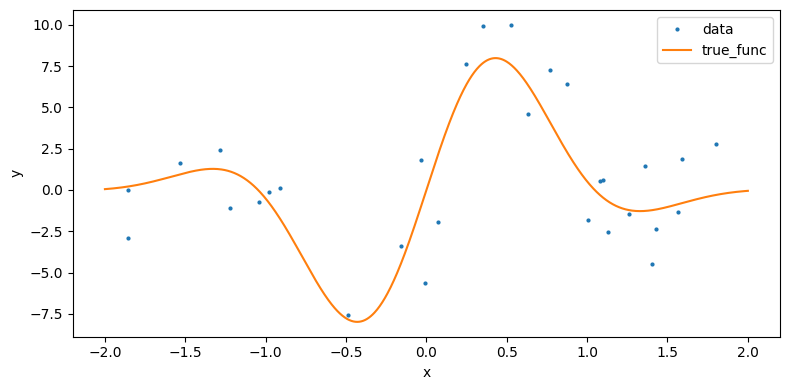

In [20]:

np.random.seed(20)

# データ数
N = 30

# 目的変数生成関数
def make_data(x, eps):
  y = 10*np.sin(3*x) * np.exp(-x**2)
  noise = np.random.normal(0, eps, size=x.shape[0])
  return y+ noise

# 説明変数をサンプリング
x_data = np.random.uniform(low=-2., high=2., size=N)
# 目的変数生成
y_data =  make_data(x_data, 2.0)
# 関数可視化用説明変数
x_linspace = np.linspace(-2., 2., 1000)
# 関数可視化用目的変数
y_linspace = make_data(x_linspace, 0.0)

fig, ax = plt.subplots(figsize=(8, 4))
ax.plot(x_data, y_data, 'o', markersize=2, label='data');
ax.plot(x_linspace, y_linspace, label='true_func')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.legend()
plt.tight_layout();

## Model setting

In [24]:
#dim of hidden layer
h1,h2 = 10,10

#Relu
def relu(x):
  return jnp.maximum(x,0)

def model(X,Y,h1,h2):
  #add bias
  X = jnp.power(X,np.arange(2)) #t element-wise exponentiation of the element of X : 0, 1 the power of x -> shape [X.shape[0],1] -> ([X.shape[0],2])
  D_X = X.shape[1] #dim of input

  #1st layer
  w1 = numpyro.sample(
      "w1",dist.Normal(jnp.zeros((D_X,h1)),10*jnp.ones((D_X,h1))).to_event(2)
  )
  z1 = relu(jnp.matmul(X,w1))
  #print("z1 shape=",z1.shape) #(30,10)
  #2nd layer
  w2 = numpyro.sample(
      "w2",dist.Normal(np.zeros((h1,h2)),10*np.ones((h1,h2))).to_event(2)
  )
  z2 = relu(jnp.matmul(z1,w2))
  #output layer
  w3 = numpyro.sample(
      "w3",dist.Normal(np.zeros((h2,1)),10*np.ones((h2,1))).to_event(2)
  )
  z3 = jnp.matmul(z2,w3)

  #observation noise
  sigma_obs = numpyro.sample("noise_obs",dist.Uniform(0,2))
  #batch_shape is equal to the num of data
  with numpyro.plate("data",X.shape[0]):
    obs = numpyro.sample("Y",dist.Normal(z3,sigma_obs).to_event(1),obs=Y)


## Inference

In [25]:
#NUTS
def run_inference(model,rng_key,X,Y,h1,h2):
  kernel = NUTS(model)
  mcmc = MCMC(
      kernel,num_warmup=1000,num_samples=2000,num_chains=1
  )
  mcmc.run(rng_key,X,Y,h1,h2)
  return mcmc.get_samples()

#convert data (N,)->(N,1)
x_data = jnp.array(x_data).reshape(-1,1)
y_data = jnp.array(y_data).reshape(-1,1)

#pseudo random number
rng_key, rng_key_predict = random.split(random.PRNGKey(0))
print(rng_key,rng_key_predict)
#inference
samples = run_inference(model,rng_key,x_data,y_data,h1,h2)


[4146024105  967050713] [2718843009 1272950319]
z1 shape= (30, 10)
z1 shape= (30, 10)


  0%|          | 0/3000 [00:00<?, ?it/s]

z1 shape= (30, 10)


sample: 100%|██████████| 3000/3000 [00:53<00:00, 55.85it/s, 1023 steps of size 4.16e-04. acc. prob=0.85]


## Prediction

z1 shape= (1000, 10)


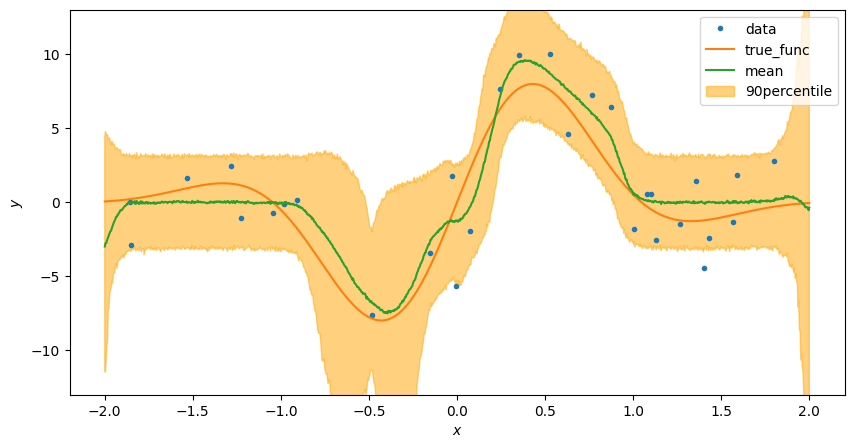

In [27]:
predictive = Predictive(model,samples)
x_new = jnp.linspace(-2,2,1000)[:,jnp.newaxis]
#predict
y_pred_samples = predictive(rng_key_predict,X=x_new,Y=None,h1=h1,h2=h2)["Y"] #(2000,1000,1)
#mean
y_pred_mean = y_pred_samples.mean(axis=0)
#90%time
percentile = np.percentile(y_pred_samples.squeeze(-1),[5,95],axis=0)

fig, ax = plt.subplots(figsize=(10, 5))
# データ可視化
ax.plot(x_data, y_data, 'o', markersize=3, label='data')
# 真の関数
ax.plot(x_linspace, y_linspace, label='true_func')
# 予測分布の平均
ax.plot(x_new, y_pred_mean, label='mean')
# 予測分布の90パーセンタイル
ax.fill_between(x_new.squeeze(-1), percentile[0, :], percentile[1, :],
                  alpha=0.5, label='90percentile', color='orange')

ax.set_xlabel(r'$x$')
ax.set_ylabel(r'$x$')
ax.set_ylabel(r'$y$')
ax.set_ylim(-13 ,13)
ax.legend();

In [29]:
print(y_pred_samples)

[[[-1.1181724 ]
  [-0.34013283]
  [ 0.49418205]
  ...
  [-1.2571017 ]
  [-2.8626156 ]
  [-2.9765055 ]]

 [[-0.69510835]
  [ 1.2957118 ]
  [-0.57990974]
  ...
  [ 3.178391  ]
  [ 1.6086223 ]
  [ 2.4749053 ]]

 [[ 2.7717931 ]
  [ 0.3872335 ]
  [ 0.06192227]
  ...
  [ 0.8677901 ]
  [-0.838223  ]
  [-1.0054814 ]]

 ...

 [[-0.9947689 ]
  [ 1.9268612 ]
  [-0.34331012]
  ...
  [-3.0417616 ]
  [ 2.4281123 ]
  [ 1.9036604 ]]

 [[ 0.17956702]
  [-2.575324  ]
  [-2.7023916 ]
  ...
  [-2.1218631 ]
  [ 1.4925905 ]
  [ 0.21340051]]

 [[-0.54844916]
  [-1.9159361 ]
  [ 2.164503  ]
  ...
  [-1.4491426 ]
  [-3.6834054 ]
  [ 1.0924466 ]]]
